In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Open the H5 file, declare number of vectors in dataset
file = h5py.File('data2.h5', 'r')
vector_count = 1000
# Create empty lists to store the preprocessed data
vector_13_data = []
vector_16_data = []
new_vec_13_data = []

# Define the zeros map
zeros_map = np.array([1, 2, 16, 17, 18, 19, 34, 35, 36, 51, 52, 53, 68, 69, 70, 85, 86, 87, 102, 103, 104, 119, 120, 121, 136, 137, 138, 153, 154, 155, 170, 171, 172, 187, 188, 189, 204, 205, 206, 221, 222, 223, 238, 239, 240, 241, 255, 256])

In [3]:
for i in range(1, vector_count+1):
    # Construct the dataset paths
    vector_13_path = f"dataset_group/vector_13_{i}"
    vector_16_path = f"dataset_group/vector_16_{i}"    
    # Load vector_13 and vector_16 from the H5 file
    vector_13 = np.array(file[vector_13_path])
    vector_16 = np.array(file[vector_16_path])

    # Remap vector_13 to new_vec_13
    remap_to_13 = np.setdiff1d(np.arange(1, 257), zeros_map)
    new_vec_13 = np.zeros(256, dtype=np.double)
    new_vec_13[remap_to_13 - 1] = vector_13
    
    # Append the remapped data to the list
    vector_13_data.append(new_vec_13)
    vector_16_data.append(vector_16)
    
# Close the H5 file
file.close()

In [4]:
# Convert the lists to numpy arrays. Needed for further functions
vector_13_data = np.array(vector_13_data)
vector_16_data = np.array(vector_16_data)

# Normalise the data (optional, lead to range issues. Update: !! Due to data leakage !! Do this after the train split. Always normalise using only training data.)
# max_value_16 = np.max(vector_16_data)
# vector_13_data = vector_13_data / np.max(vector_13_data)
# vector_16_data = vector_16_data / np.max(vector_16_data)

# Reshape vector_13_data to (1000, 256) and vector_16_data to (1000, 256) for batches of vectors to feed into the NN
vector_13_data = np.reshape(vector_13_data, (vector_count, 256))
vector_16_data = np.reshape(vector_16_data, (vector_count, 256))

In [5]:
# Split the dataset into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * vector_13_data.shape[0])

x_train = vector_13_data[:train_size]
y_train = vector_16_data[:train_size]

x_test = vector_13_data[train_size:]
y_test = vector_16_data[train_size:]

x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [6]:
#Legacy: Normalisation. Leads to problems. Refer documentation.

# ## Normalise the data
# max_value_13 = np.max(x_train)
# max_value_16 = np.max(y_train)

# x_train = x_train / max_value_13
# y_train = y_train / max_value_16

# ## Normalise the test data using the same max values as the training data... Trying to avoid data leakage here
# x_test = x_test / max_value_13
# y_test = y_test / max_value_16


In [7]:
# Sanity check
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
def create_mask(zeros_map, vector_length):
    mask = np.ones(vector_length, dtype=np.double)
    mask[zeros_map - 1] = 0.0
    return mask

# Create the mask
mask = create_mask(zeros_map, 256)

# Reshape the mask to match the shape of the input
mask = np.reshape(mask, (1, 256))

# Make sure the mask is in the same type as the training data
mask = mask.astype(np.float32)

# Convert to tensorflow constant
mask = tf.constant(mask)

In [9]:
#Activation function: reLu

# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(256,)))
# model.add(Dense(256))
# model.add(Dense(256))  # Add another dense layer
# model.add(Dense(256))  # Add another dense layer
# model.add(Dense(256))  # Add another dense layer
# model.add(Dense(256 * 1, activation='linear'))  # Output layer with shape (256, 1)

# model.summary()

In [10]:
#Activation function: tanh

# model = Sequential()
# model.add(Dense(128, activation='tanh', input_shape=(256,)))
# model.add(Dense(256, activation='tanh'))
# model.add(Dense(256, activation='tanh'))
# model.add(Dense(256, activation='linear'))  # Output layer

# model.summary()

In [11]:
# #Activation function: leakyReLU

# from tensorflow.keras.layers import LeakyReLU

# model = Sequential()
# model.add(Dense(128, input_shape=(256,)))
# model.add(LeakyReLU(alpha=0.01))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.01))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.01))
# model.add(Dense(256, activation='linear'))  # Output layer

# model.summary()

In [12]:
# #Activation function: ELU

model = Sequential()
model.add(Dense(128, activation='elu', input_shape=(256,)))
model.add(Dense(256, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(256, activation='linear'))  # Output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
Total params: 197,504
Trainable params: 197,504
Non-trainable params: 0
_________________________________________________________________


In [13]:
# #Activation function: swish

# from tensorflow.keras.activations import swish

# model = Sequential()
# model.add(Dense(128, activation=swish, input_shape=(256,)))
# model.add(Dense(256, activation=swish))
# model.add(Dense(256, activation=swish))
# model.add(Dense(256, activation='linear'))  # Output layer

In [14]:
# Compile the model with a default learning rate of 0.001 (works better for some reason?!)
# model.compile(optimizer='adam', loss='mean_squared_error')

# Compile the model with a lower learning rate
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')


In [15]:
# Custom loss function with regularization for sum to zero constraint
class CustomMSEWithSumReg(tf.keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, **kwargs):
        super().__init__(**kwargs)
        self.regularization_factor = regularization_factor
        self.mse = tf.keras.losses.MeanSquaredError()

    def call(self, y_true, y_pred):
        # Compute the MSE loss
        mse_loss = self.mse(y_true, y_pred)

        # Compute the sum of every 16 values in the predictions
        y_pred_reshaped = tf.reshape(y_pred, (-1, 16))
        sums = tf.reduce_sum(y_pred_reshaped, axis=1)
        
        # Add the regularization term to the loss
        sum_reg_loss = tf.math.reduce_mean(tf.math.square(sums)) * self.regularization_factor

        return mse_loss + sum_reg_loss

In [16]:
# Custom loss function with regularization for sum to zero constraint
class CustomMAEWithSumReg(tf.keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, **kwargs):
        super().__init__(**kwargs)
        self.regularization_factor = regularization_factor
        self.mae = tf.keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        # Compute the MAE loss
        mae_loss = self.mae(y_true, y_pred)

        # Compute the sum of every 16 values in the predictions
        y_pred_reshaped = tf.reshape(y_pred, (-1, 16))
        sums = tf.reduce_sum(y_pred_reshaped, axis=1)
        
        # Add the regularization term to the loss
        sum_reg_loss = tf.math.reduce_mean(tf.math.abs(sums)) * self.regularization_factor

        return mae_loss + sum_reg_loss

In [17]:
# Set the training parameters
epochs = 1000
batch_size = 32

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

# Define the loss function and the optimizer
#loss_object = tf.keras.losses.MeanSquaredError()
loss_object = CustomMSEWithSumReg(regularization_factor=0.1)
optimizer = tf.keras.optimizers.Adam()

# Define the function for the forward pass, the calculation of the loss, and the backward pass (applying the gradients)
@tf.function #Eager bla bla if you dont have this in
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(x)
        # Calculate the loss
        masked_output = predictions * mask
        masked_y = y * mask
        loss = loss_object(masked_y, masked_output)
    # Backward pass (calculate gradients and apply them to the model's parameters)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Custom training loop
for epoch in range(epochs):
    total_loss = 0.0
    num_batches = 0
    for x, y in train_dataset:
        total_loss += train_step(x, y)
        num_batches += 1
    train_loss = total_loss / num_batches
    print('Epoch {0} - Loss: {1}'.format(epoch, train_loss))

# Evaluate the model on the test set
total_loss = 0.0
num_batches = 0
for x, y in test_dataset:
    # Forward pass
    predictions = model(x)
    # Calculate the loss
    masked_output = predictions * mask
    masked_y = y * mask
    loss = loss_object(masked_y, masked_output)
    total_loss += loss
    num_batches += 1
test_loss = total_loss / num_batches
print('Test Loss: {0}'.format(test_loss))


Epoch 0 - Loss: 1.5143622159957886
Epoch 1 - Loss: 1.4203037023544312
Epoch 2 - Loss: 1.4764165878295898
Epoch 3 - Loss: 1.339509129524231
Epoch 4 - Loss: 1.399263858795166
Epoch 5 - Loss: 1.2163493633270264
Epoch 6 - Loss: 1.3499460220336914
Epoch 7 - Loss: 1.1870834827423096
Epoch 8 - Loss: 1.1992751359939575
Epoch 9 - Loss: 1.101176381111145
Epoch 10 - Loss: 1.2166184186935425
Epoch 11 - Loss: 1.2624082565307617
Epoch 12 - Loss: 1.074224591255188
Epoch 13 - Loss: 0.9706922173500061
Epoch 14 - Loss: 0.9486151933670044
Epoch 15 - Loss: 0.9726985096931458
Epoch 16 - Loss: 1.0395737886428833
Epoch 17 - Loss: 0.9215344786643982
Epoch 18 - Loss: 0.7932647466659546
Epoch 19 - Loss: 0.9004802107810974
Epoch 20 - Loss: 1.0697590112686157
Epoch 21 - Loss: 0.8385199904441833
Epoch 22 - Loss: 0.7290696501731873
Epoch 23 - Loss: 0.9406242966651917
Epoch 24 - Loss: 0.7861201763153076
Epoch 25 - Loss: 0.7518510222434998
Epoch 26 - Loss: 0.7917523384094238
Epoch 27 - Loss: 0.8014906048774719
Epoch 

In [18]:
# Evaluation (Normalised block)
# y_pred_test = model.predict(x_test)

# Reverse the normalization of the predictions and the target values
# y_pred_test = y_pred_test * max_value_16
# y_test_denorm = y_test * max_value_16

In [19]:
# Evaluation / Testing
y_pred_test = model.predict(x_test)

# Select a random index from the test set
random_index = np.random.randint(low=0, high=y_test.shape[0])
random_index = 12 #diagnostic stuff

# Select the predicted and ground truth vectors at the random index
predicted_vector = y_pred_test[random_index]
# ground_truth_vector = y_test_denorm[random_index] #Normalised? Use this
ground_truth_vector = y_test[random_index]

# Print the selected vectors for comparison
print("Predicted Vector:")
print(predicted_vector)
print("Ground Truth Vector:")
print(ground_truth_vector)


7/7 [==============================] - 0s 1ms/step
Predicted Vector:
[-2.47392997e-01  7.91949257e-02  3.49984318e-02  1.87058151e-02
  5.98960966e-02  2.18152478e-02 -8.38106871e-03 -1.71817392e-02
 -4.37262058e-02 -3.46544124e-02 -7.25077093e-03 -5.62769361e-03
 -4.04118448e-02 -3.38673219e-02  5.52383065e-03  1.77006096e-01
 -1.21868268e-01  7.28865042e-02  2.25960195e-01  1.26745850e-01
  3.38177010e-02 -1.25347301e-02  6.32925034e-02 -2.61879265e-02
 -1.04573369e-02 -3.09589822e-02  3.58893462e-02  4.98482883e-02
  3.94848362e-03 -1.54270902e-02  3.80765088e-03  2.07357258e-02
  4.60275635e-02  2.85079777e-01  1.13562971e-01  2.76369005e-01
  9.73324403e-02  1.83889233e-02  2.03403970e-03 -4.34272364e-02
 -1.18211620e-02 -6.35291636e-02 -1.63613204e-02 -2.97522154e-02
 -1.11310184e-02  2.81564370e-02  2.40900442e-02 -4.19801697e-02
 -2.34601647e-03  1.38649598e-01  1.15002804e-01 -2.42118627e-01
  1.41312972e-01  6.87034503e-02 -1.39992125e-02 -4.44687381e-02
 -3.71287279e-02 -8.5

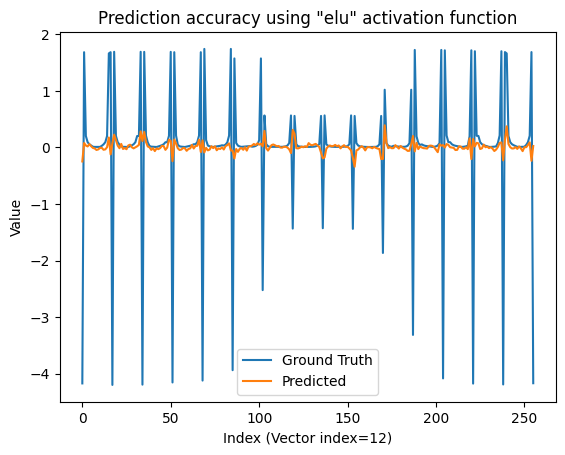

In [20]:
import matplotlib.pyplot as plt

# Create x-axis values for the plot
x = range(len(ground_truth_vector))

# Plot the ground truth and predicted vectors
plt.plot(x, ground_truth_vector, label='Ground Truth', color='C0')
plt.plot(x, predicted_vector, label='Predicted', color='C1')

# Set plot labels and legend
plt.xlabel(f'Index (Vector index={random_index})')
plt.ylabel('Value')
plt.legend()

# Get the activation function of the first layer
activation_function = model.layers[0].get_config()['activation']
plt.title(f'Prediction accuracy using "{activation_function}" activation function')

# Show the plot
plt.show()

In [20]:
#Further diagnostic stuff, ignore
## Get the shown vector in the test set
#needed_index = vector_count*train_ratio+random_index
#_test_vector = vector_16_data[needed_index]

#print(_test_vector)

## Print the flattened vector
#print(_test_vector.flatten())